# DNN DeepSpech

## COMPARISON OF MULTIPLE FEATURES AND MODELING METHODS FORTEXT-DEPENDENT SPEAKER VERIFICATION
### https://arxiv.org/pdf/1707.04373.pdf

#### Features
1. MFCC: MFCCs are extracted from 16kHz utterance with 40 filter-banks distributed between 0 and 8kHz. Static 19-dimensional coefficients plus energy and their delta and delta-delta form a 60-dimensional vector. CMVN is applied per utterance.
2. FBank: FBank computation has the same steps with MFCC extraction, except that no DCT transform is applied. The  Fbank coefficient is 120 dimension (40 + ∆ + ∆∆).
3. BN feature: BN features are extracted from phonetic and speaker discriminant DNNs. We denote them as pBN and sBN, respectively. The configuration of the DNN structure is described below.

#### Models
1. DNN: The training data is a subset from Librispeech and RSR2015, containing about 460 and 50 hours respectively.  The fully connected  DNN  consists  of  4  hidden  layers  with  1200  nodes  per layer, plus a BN layer with 60 nodes. The input is FBank with symmetric 5-frame expansion, resulting in 11 frames in total. The number  of  nodes  in  the  output  layer  is  determined  by  different tasks. For  phoneme  classification,  we  use  2142  tied  triphonestates  and  for  speaker  classification, 1472  speaker  identities (1172  from  Librispeech  and  300  from  RSR2015) become the corresponding outputs. BN features are the linear outputs of the last hidden layer without any activation function.
2. GMM-UBM and i-vector: A gender-dependent UBM with 1024 mixtures is trained. For i-vector modeling, the rank of the matrix T is 600. Log-likelihood without normalization and cosine distance is used to generate verification scores in these two systems respectively.
3. HMM: To generate the alignment for the HMM-based modeling, we use MFCCs to train the HMM. 39 mono-phones plus a silence model are used, each of which contains 3 states. To model the complexity of silence, a GMM with 16 mixtures is used for every silence state, while other states are all modeled by 8 Gaussians, resulting 984 Gaussians in total. This HMM is further extended to a triphone system and remains 2142 senones. The transcriptions for DNN  training  is  generated  by  the  senone  alignment. Only MFCCs are used for HMM training and alignment.
4. GMM-HMM and i-vector/HMM: The GMM of every state is reestimated using the HMM alignments and different speaker features. The total number of mixtures in our model is 984. The dimension of i-vector is again set to 600. Viterbi and FB alignments are both investigated.

In [5]:
# from tensorflow.contrib.session_bundle import exporter

# from deepspeech import model
# # from deepspeech.model import Model

# help(ds.client)

AttributeError: module 'deepspeech' has no attribute 'client'

In [8]:
import concurrent.futures as cf
import functools as ft
import itertools as it
import json
import math
import operator as op
import os
import re
import sys

from IPython.display import display
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import interpolate, linalg, misc, optimize, spatial, stats
from sklearn import metrics, mixture, cluster, utils
import tensorflow as tf
from deepspeech.utils import audioToInputVector

# Load

In [19]:
with open('paths.json') as opened:
    paths = json.load(opened)
    
root = paths['reddots_root']
deepspeech_root = paths['deepspeech_root']

# sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [12]:
def audiofile_to_input_vector(audio_filename, fs=16000, numcep=26, numcontext=9):
    audio = np.fromfile(audio_filename, np.int16)
    return audioToInputVector(audio, 16000, numcep, numcontext)

In [16]:
all_paths = [os.path.join(os.path.basename(root), file) for root, _, files in os.walk(root + '/pcm') 
                                      for file in files 
                                      if file.endswith('.pcm')]
print(len(all_paths), all_paths[0])

15305 f0002/20150224142650384_f0002_14438.pcm


In [18]:
all_mfcc = {path: audiofile_to_input_vector(root + '/pcm/' + path) for path in all_paths}

In [49]:
script = pd.read_csv(root + '/infos/phones.csv', sep=';')
print(script.loc[script['sentence_id'] == 31])

      sentence_id                  content  \
1609           31  My voice is my password   

                                                 phones  
1609  M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D  


In [50]:
def load_sets(eid, tid=None):
    tid = tid if tid else eid
    
    enrollments = reddots.load_enrollments(root + '/ndx/f_part_{}.trn'.format(eid), 
                                           root + '/ndx/m_part_{}.trn'.format(eid))
    trials = reddots.load_trials(root + '/ndx/f_part_{}.ndx'.format(tid), 
                                 root + '/ndx/m_part_{}.ndx'.format(tid))
    
    enrollments = enrollments.merge(script, how='left', on='sentence_id')
    trials = trials.merge(script, how='left', left_on='expected_sentence_id', right_on='sentence_id')
    del trials['sentence_id']
    trials.rename(columns={'content': 'expected_content', 'phones': 'expected_phones'}, inplace=True)
    trials = trials.merge(script, how='left', left_on='trial_sentence_id', right_on='sentence_id')
    del trials['sentence_id']
    trials.rename(columns={'content': 'trial_content', 'phones': 'trial_phones'}, inplace=True)
    
    return enrollments, trials

In [51]:
enrollments_1, trials_1 = load_sets('01')
print('Enrollments', enrollments_1.dtypes, sep='\n')
print('Trials', trials_1.dtypes, sep='\n')

Enrollments
is_male                  bool
pcm_path               object
sentence_id             int16
speaker_id              int16
timestamp      datetime64[ns]
content                object
phones                 object
dtype: object
Trials
correct_sentence                  bool
expected_is_male                  bool
expected_sentence_id             int16
expected_speaker_id              int16
pcm_path                        object
target_person                     bool
trial_is_male                     bool
trial_sentence_id                int16
trial_speaker_id                 int16
trial_timestamp         datetime64[ns]
expected_content                object
expected_phones                 object
trial_content                   object
trial_phones                    object
dtype: object


In [81]:
enrollments_2, trials_2 = load_sets('02')
enrollments_3, trials_3 = load_sets('03')
enrollments_4_td, trials_4_td = load_sets('04_td', '04')

In [106]:
trialed_paths = set(path for trials in (trials_1, trials_2, trials_3, trials_4_td) for path in trials.pcm_path)
untrialed_paths = [path for path in all_paths if path not in trialed_paths]
print(len(trialed_paths), len(untrialed_paths))

10857 4448


In [107]:
trialed_paths = [path for path in trialed_paths if all_mfcc[path].shape[0] >= 85]
untrialed_paths = [path for path in untrialed_paths if all_mfcc[path].shape[0] >= 85]

In [127]:
def write_model(path, model):
    with open(path, 'wb') as opened:
        pickle.dump(model, opened)
        
def read_model(path):
    with open(path, 'rb') as opened:
        return pickle.load(opened)
    
def save_results(label, results):
    path = os.path.join(root, 'result', 'dnn', label)
    with open(path, 'wb') as opened:
        pickle.dump(results, opened)
        
def load_results(label):
    path = os.path.join(root, 'result', 'dnn', label)
    with open(path, 'rb') as opened:
        return pickle.load(opened)

# Train

LSTM training done for us by Mozilla team! :)

## Align frames using LSTM

In [76]:
def load_graph(model_file_path):
    with tf.gfile.GFile(model_file_path, 'rb') as opened:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(opened.read())
        return graph_def

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def run_inference(graph_def, mfccs, mfcc_lens):
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="prefix")

        results = []
        with tf.Session(graph=graph) as session:
            # we are interested only into logits, not CTC decoding
            inputs = {'input': graph.get_tensor_by_name('prefix/input_node:0'),
                      'input_lengths': graph.get_tensor_by_name('prefix/input_lengths:0')}
            outputs = {'outputs': graph.get_tensor_by_name('prefix/logits:0')}

            for mfcc, mfcc_len in zip(mfccs, mfcc_lens):
                output = session.run(outputs['outputs'], feed_dict={
                    inputs['input']: [mfcc],
                    inputs['input_lengths']: [mfcc_len]
                })
                results.append(output)
            
        return results

#             text = alphabet.string_from_label(char_index)
#             for i in range(0, len(output)):
#                 softmax_output = softmax(output[i][0])

In [28]:
graph_def = load_graph(deepspeech_root + '/models/output_graph.pb')

In [70]:
alphabet = np.array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
                     'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "*"])

def decode_max(alphabet, inference):
    return ''.join(alphabet[n] for n in inference[:, 0, :].argmax(axis=1))

def decode_max_nonoise(alphabet, inference):
    return ''.join(alphabet[n] for n in inference[:, 0, :-1].argmax(axis=1))

In [79]:
example_mfccs = [all_mfcc[path] for path in (
    'm0002/20150713085938321_m0002_31.pcm', 'f0008/20150411081830530_f0008_31.pcm',
    'm0005/20150527153345950_m0005_31.pcm', 'm0043/20150401161616565_m0043_31.pcm'
)]
example_inferences = run_inference(graph_def, example_mfccs, list(map(len, example_mfccs)))
print(*[inference.shape for inference in example_inferences])

(94, 1, 29) (163, 1, 29) (149, 1, 29) (188, 1, 29)


In [80]:
for i, inference in enumerate(example_inferences):
    print(i, decode_max(alphabet, inference))
    
print()
for i, inference in enumerate(example_inferences):
    print(i, decode_max_nonoise(alphabet, inference))

0 ******m*y****   v*o**ii*c******e**s****  *m*a*****p*o***s*****bbllee**************************
1 *************************************mmy*********  v*o****ii**cce*****  **isss*****  mmy****** pp*a*ss**s**********rr*d********************************************
2 ********************************************m*y***** vvo****ii*c***  *i***ss**  mmy****  b*o******e*ss*****w**o******ddd*****************************
3 **************************************m*y******  *v*o*******see**************  *hi*ss*  *m*ig**t*  b*uss*****p**o**rr***********************************************************************

0 boff  mmyylre   voooiiiicee   eeesss t    mlaarr  ppouusssssiibbllee iddd bhannnneeeeeeeeeaaee
1 whoaahaaahuuaammmhhmaaaaarmmdddddf  mmmyymmry ree  vvoouwiiiiccceeddd   diissss  is  mmyyg ht  pppaasssssswouu wworrrdddddeerbbbbenneeedsssssss ssssdsdeessseeaaaey
2 thhmhhmmmmmmmmmmmmammmmmmmmmmmmmmmmmmmmff  mmmyyy e  vvoolliiiccce    iii'sss   mmyyne   blolwllleeysss   wwlooarrrrdddddds    d

In [83]:
def infer_all(all_mfcc, graph_def):
    path_sequence = []
    mfcc_sequence = []
    mfcc_len_sequence = []

    for path, mfcc in all_mfcc.items():
        path_sequence.append(path)
        mfcc_sequence.append(mfcc)
        mfcc_len_sequence.append(len(mfcc))

    inferences_sequence = run_inference(graph_def, mfcc_sequence, mfcc_len_sequence)

    all_inferences = {path: inference for path, inference in zip(path_sequence, inferences_sequence)}
    return all_inferences

all_inferences = infer_all(all_mfcc, graph_def)

In [87]:
# save_results('all_inferences.pickle', all_inferences)

In [103]:
print(decode_max(alphabet, example_inference))
print(decode_max_nonoise(alphabet, example_inference))

******m*y****   v*o**ii*c******e**s****  *m*a*****p*o***s*****bbllee**************************
boff  mmyylre   voooiiiicee   eeesss t    mlaarr  ppouusssssiibbllee iddd bhannnneeeeeeeeeaaee


## Assign frames to classes

In [215]:
def assign_classes_spread(inference):
    frame_n = inference.shape[0]
    noise_k = inference.shape[2] - 1
    
    assignment = inference[:, 0, :].argmax(axis=1)
    assignment_no_noise = inference[:, 0, :-1].argmax(axis=1)
    
    prev_k = noise_k
    for i in range(frame_n):
        if assignment[i] == assignment_no_noise[i]:
            prev_k = assignment[i]
        elif assignment[i] == noise_k and assignment_no_noise[i] == prev_k:
            assignment[i] = prev_k
    
    next_k = noise_k
    for i in range(frame_n - 1, 0, -1):
        if assignment[i] == assignment_no_noise[i]:
            prev_k = assignment[i]
        elif assignment[i] == noise_k and assignment_no_noise[i] == prev_k:
            assignment[i] = prev_k
            
    return assignment
    
print(''.join(alphabet[n] for n in assign_classes_spread(example_inferences[2])))

def assign_classes_known(inference, content):
    frame_n = inference.shape[0]
    noise_k = inference.shape[2] - 1
    
    return content
    
print(assign_classes_known(example_inferences[2], script[script.sentence_id == 31].content.iloc[0].lower()))

def assign_classes(inference):
    assignment = inference[:, 0, :].argmax(axis=1)
    return assignment

print(''.join(alphabet[n] for n in assign_classes(example_inferences[2])))

***m**mmmmmmmmmmmm*mmmmmmmmmmmmmmmmmmmm****mmmyyy *  vvoo**iiiccc*    iii*sss   mmyy**   b*o*****ee*sss***ww*oo*****dddddd*****d*d**ddddddd********dd
my voice is my password
********************************************m*y***** vvo****ii*c***  *i***ss**  mmy****  b*o******e*ss*****w**o******ddd*****************************


In [160]:
# all_assignments = {path: assign_classes(inference) for path, inference in all_inferences.items()}
all_assignments = {path: assign_classes_spread(inference) for path, inference in all_inferences.items()}

## Build per-speaker per-class GMMs

In [161]:
letter_classes = np.arange(1, 27)

def is_accepted_class(k):
    return 1 <= k < 27

In [162]:
def build_class_stacks(all_assignments, paths):
    stacks = {klass: [] for klass in letter_classes}
    
    for path in paths:
        mfcc = all_mfcc[path]
        assignments = all_assignments[path]
        for klass, frame in zip(assignments, mfcc):
            if is_accepted_class(klass):
                stacks[klass].append(frame)
    
    stacks = {klass: np.vstack(frames) for klass, frames in stacks.items() if frames}
    return stacks

class_stacks = build_class_stacks(all_assignments, untrialed_paths)

In [180]:
def train_class_ubm(stack):
    ubm = mixture.GaussianMixture(
        n_components=16, max_iter=2000, covariance_type='diag', 
        random_state=13, verbose=1
    )
    ubm.fit(stack)
    return ubm

class_ubms = {klass: train_class_ubm(stack) for klass, stack in class_stacks.items()}

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: T

In [181]:
write_model(root + '/models/dnn/ubm_models_2.pickle', class_ubms)

# Enroll
## Speaker scores

In [182]:
def load_ubms_copy():
    return read_model(root + '/models/dnn/ubm_models_2.pickle')

def map_adapt(gmm, features, relevance_factor=3.0):
    proba = gmm.predict_proba(features)
    zero_stats = proba.sum(axis=0)
    first_stats = proba.T @ features
    new_means = first_stats / zero_stats[:, np.newaxis]
    new_means[~np.isfinite(new_means)] = gmm.means_[~np.isfinite(new_means)]
    replace_factor = zero_stats / (zero_stats + relevance_factor)
    adapted_means = gmm.means_ + replace_factor[:, np.newaxis] * (new_means - gmm.means_)
    gmm.means_ = adapted_means
    
# example = load_ubm_copy()
# map_adapt(example, speaker_stack)
# example

In [183]:
def split_enrollments(enrollments):
    unique_males = enrollments[enrollments.is_male].speaker_id.unique()
    unique_females = enrollments[~enrollments.is_male].speaker_id.unique()
    unique_sentences = enrollments.sentence_id.unique()
    return unique_males, unique_females, unique_sentences

def map_adapt_classes(speaker_gmms, speaker_stacks):
    for klass, stack in speaker_stacks.items():
        speaker_gmm = speaker_gmms[klass]
        map_adapt(speaker_gmm, stack)

def enroll_speakers(all_assignments, enrollments):
    males, females, _ = split_enrollments(enrollments)
    
    speaker_class_gmms = {}
    for is_male, speaker_ids in ((True, males), (False, females)):
        for speaker_id in speaker_ids:
            speaker_mask = (enrollments.is_male == is_male) & (enrollments.speaker_id == speaker_id)
            speaker_paths = enrollments[speaker_mask].pcm_path
            speaker_gmms = load_ubms_copy()
            
            speaker_stacks = build_class_stacks(all_assignments, speaker_paths)
            map_adapt_classes(speaker_gmms, speaker_stacks)
            
            speaker_class_gmms[(is_male, speaker_id)] = speaker_gmms
            
    return speaker_class_gmms

In [184]:
enrollments_1_speaker_class_gmms = enroll_speakers(all_assignments, enrollments_1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [167]:
# fast - not really need to save as long as we have ubms
# write_model(root + '/models/dnn/enrollment_1_speaker_class_gmms_1.pickle', enrollments_1_speaker_class_gmms)

## Sentence scores
TODO

In [105]:
def extract_informative_labels(alphabet, inference):
    noise_n = inference.shape[2] - 1
    
    maxima = inference[:, 0, :].argmax(axis=1)
    informative_mask = maxima != noise_n
    informative_values = maxima[informative_mask]
    
    return alphabet[informative_values]
    
extract_informative_labels(alphabet, example_inference)

# Evaluate

In [185]:
def score_class_gmm(class_gmms, assignments, features):
    total_proba = 0
    for klass, frame in zip(assignments, features):
        if is_accepted_class(klass):
            class_gmm = class_gmms[klass]
            proba = class_gmm.score([frame])
            total_proba += proba
    return total_proba

In [186]:
ubm_scores = {path: score_class_gmm(class_ubms, all_assignments[path], all_mfcc[path]) for path in trialed_paths}

In [187]:
def perform_trials(ubm_scores, speaker_scores, sentence_scores, 
                   speaker_class_gmms, all_assignments, all_mfcc, trials):
    size = len(trials)
    
    scores = np.zeros((size, 3), dtype=np.float64)
    flags = np.zeros((size, 6), dtype=np.bool)
    
    for i, trial in trials.iterrows():
        try:
            ubm_score = ubm_scores[trial.pcm_path]
        except KeyError:
            flags[i, 5] = True
            continue
            
        key1 = (trial.expected_is_male, trial.expected_speaker_id, trial.pcm_path)
        if key1 in speaker_scores:
            speaker_score = speaker_scores[key1]
        else:
            class_gmms = speaker_class_gmms[(trial.expected_is_male, trial.expected_speaker_id)]
            assignment = all_assignments[trial.pcm_path]
            recording = all_mfcc[trial.pcm_path]
            speaker_score = score_class_gmm(class_gmms, assignment, recording)
            speaker_scores[key1] = speaker_score
            
#         key2 = (trial.expected_sentence_id, trial.pcm_path)
#         if key2 in sentence_scores:
#             sentence_score = sentence_scores[key2]
#         else:
#             sentence_gmm = sentence_gmms[trial.expected_sentence_id]
#             recording = all_mfcc[trial.pcm_path]
#             sentence_score = sentence_gmm.score(recording)
#             sentence_scores[key2] = sentence_score
        sentence_score = ubm_score
        
        expected_is_male = trial.expected_is_male
        trial_is_male = trial.trial_is_male
        gender_right = trial.expected_is_male == trial.trial_is_male
        target_right = gender_right and (trial.expected_speaker_id == trial.trial_speaker_id)
        sentence_right = trial.expected_sentence_id == trial.trial_sentence_id
        
        scores[i, :] = (speaker_score, sentence_score, ubm_score)
        flags[i, :] = (expected_is_male, trial_is_male, gender_right, target_right, sentence_right, False)
        
    return pd.DataFrame.from_dict({
        'speaker_score': scores[:, 0], 'sentence_score': scores[:, 1], 'ubm_score': scores[:, 2],
        'expected_is_male': flags[:, 0], 'trial_is_male': flags[:, 1], 'gender_right': flags[:, 2],
        'target_right': flags[:, 3], 'sentence_right': flags[:, 4], 'too_short': flags[:, 5]
    })

In [188]:
speaker_scores = {}
sentence_scores = {}

In [189]:
trials_1_results = perform_trials(ubm_scores, speaker_scores, sentence_scores, 
                                  enrollments_1_speaker_class_gmms, all_assignments, all_mfcc, trials_1)

In [190]:
save_results('ubm_scores_2.pickle', ubm_scores)
save_results('speaker_scores_2.pickle', speaker_scores)
# save_results('sentence_scores.pickle', sentence_scores)
trials_1_results.to_pickle(os.path.join(root, 'result', 'dnn', 'trials_1_results_2.pickle.gz'), compression='gzip')

# Visualize

In [191]:
def equal_error_rate(fpr, tpr, thresholds):
    eer = optimize.brentq(lambda x : 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
    threshold = interpolate.interp1d(fpr, thresholds)(eer)
    return eer, threshold

def plot_roc(fpr, tpr, auc, eer, title):
    plt.figure(figsize=(8, 6))
    print(auc, eer)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.2%}, EER = {:.2%})'.format(auc, eer))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
def visualize_roc(fpr, tpr, thresholds, title=None):
    roc_auc = metrics.auc(fpr, tpr)
    eer, threshold = equal_error_rate(fpr, tpr, thresholds)
    plot_roc(fpr, tpr, roc_auc, eer, title=title)
    
def visualize_results(results):
    # is target right, disregarding sentence
    roc_target_right = metrics.roc_curve(results.target_right, results.speaker_prob)
    visualize_roc(*roc_target_right, title='ROC - speaker correct problem')

    # is sentence correct or wrong, disregarding target
    roc_sentence_right = metrics.roc_curve(results.sentence_right, results.sentence_prob)
    visualize_roc(*roc_sentence_right, title='ROC - sentence correct problem')

    # is target right, when the sentence is correct
    roc_both_right = metrics.roc_curve(results.target_right & results.sentence_right, results.both_prob)
    visualize_roc(*roc_both_right, title='ROC - speaker and sentence correct problem')

In [192]:
trials_1_results['speaker_prob'] = np.exp(trials_1_results.speaker_score - np.maximum(trials_1_results.ubm_score, trials_1_results.speaker_score))
trials_1_results['sentence_prob'] = np.exp(trials_1_results.sentence_score - np.maximum(trials_1_results.ubm_score, trials_1_results.sentence_score))
trials_1_results['both_prob'] = np.exp(trials_1_results.speaker_score - np.maximum(trials_1_results.ubm_score, trials_1_results.speaker_score)
                                     + trials_1_results.sentence_score - np.maximum(trials_1_results.ubm_score, trials_1_results.sentence_score))

0.716956444725 0.34348676230198893


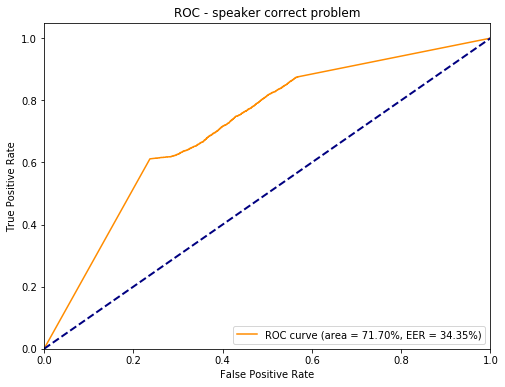

0.5 0.5


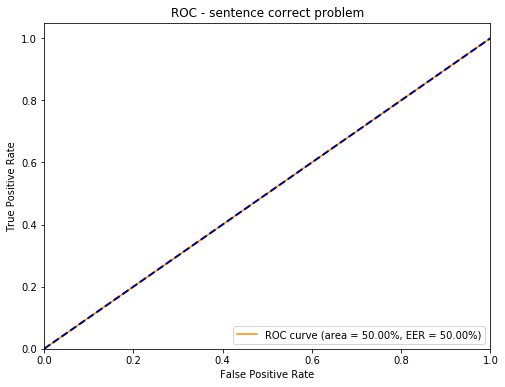

0.716932185959 0.34116059379217467


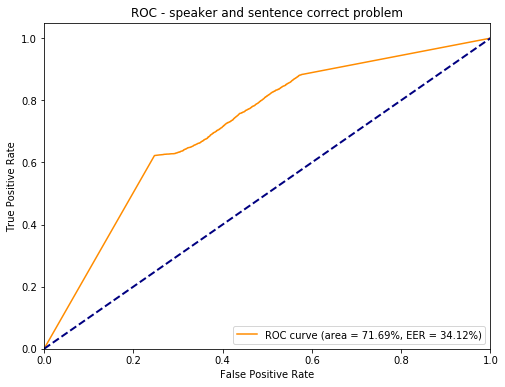

In [193]:
# spread 16
visualize_results(trials_1_results[~trials_1_results.too_short])

0.731268394452 0.32871297485122536


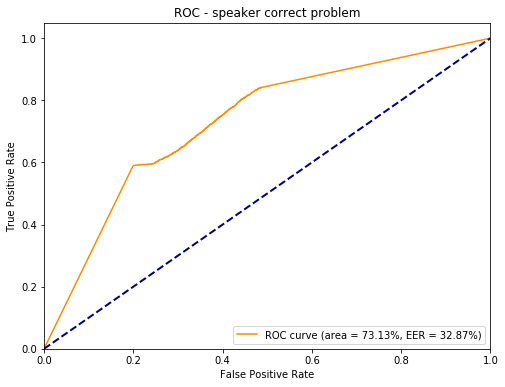

0.5 0.5


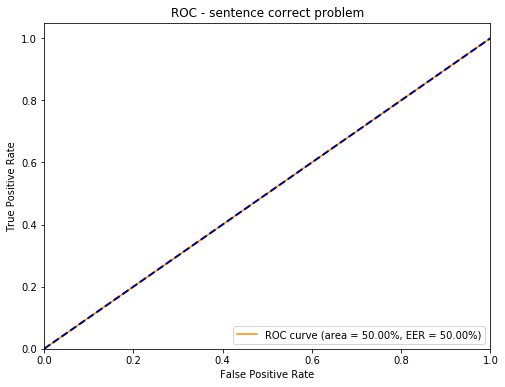

0.729281755166 0.32928475033738247


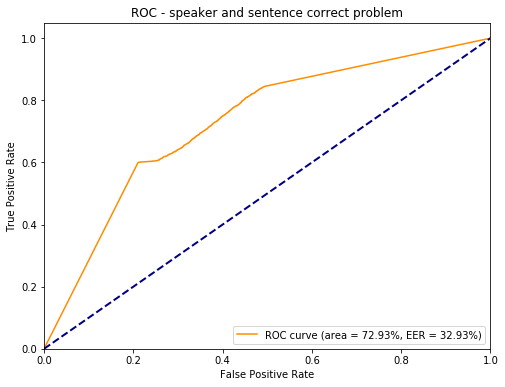

In [179]:
# spread 8
visualize_results(trials_1_results[~trials_1_results.too_short])

0.736308253815 0.32295320848399817


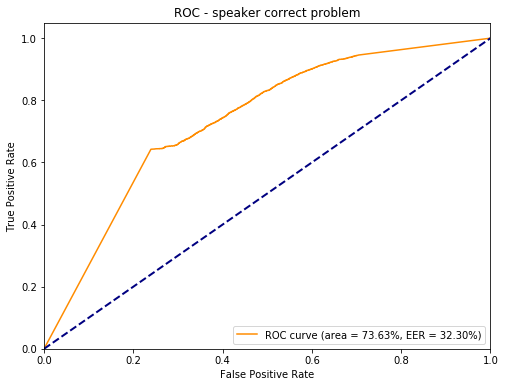

0.5 0.5


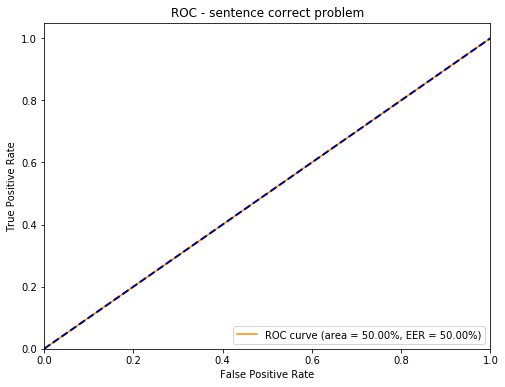

0.735155036296 0.3214574898789079


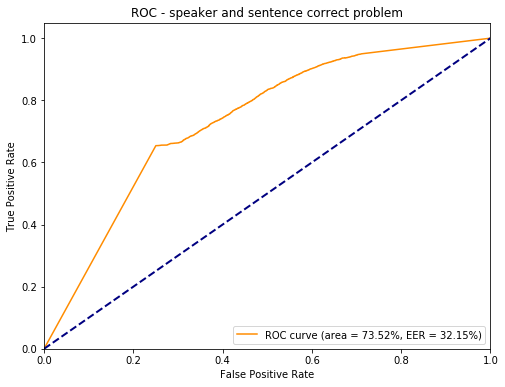

In [146]:
# nospread 8
visualize_results(trials_1_results[~trials_1_results.too_short])